# Project HealthTech: Hospital Readmission Risk Prediction

### Problem Context

Hospitals face high costs associated with early readmissions. Identifying high-risk patients allows for:

- Implementing post-discharge follow-up
- Optimizing clinical resources
- Reducing regulatory penalties
- Improving quality of care

### Project Objective

To develop a model that predicts whether a patient will be readmitted, using clinical and administrative information available at the time of discharge.

### Central Question

Can we identify patients at high risk of readmission using demographic, clinical, and prior healthcare utilization data?


# About Dataset

Ten years patient information (kaggle):

Information in the file by categories:

**1. Demographics:**
-  "age" - age bracket of the patient

**2. Complexity of the clinical case**

- "time_in_hospital" - days (from 1 to 14)
- "n_procedures" - number of procedures performed during the hospital stay
- "n_lab_procedures" - number of laboratory procedures performed during the hospital stay
- "n_medications" - number of medications administered during the hospital stay

**3. Prior use of the health system**

- "n_outpatient" - number of outpatient visits in the year before a hospital stay
- "n_inpatient" - number of inpatient visits in the year before the hospital stay
- "n_emergency" - number of visits to the emergency room in the year before the hospital stay

**4. Clinic context**

- "medical_specialty" - the specialty of the admitting physician
- "diag_1" - primary diagnosis (Circulatory, Respiratory, Digestive, etc.)
- "diag_2" - secondary diagnosis
- "diag_3" - additional secondary diagnosis

**5. Diabetes managment**

- "glucose_test" - whether the glucose serum came out as high (> 200), normal, or not performed
- "A1Ctest" - whether the A1C level of the patient came out as high (> 7%), normal, or not performed
- "change" - whether there was a change in the diabetes medication ('yes' or 'no')
- "diabetes_med" - whether a diabetes medication was prescribed ('yes' or 'no')

**Target:**

- "readmitted" - if the patient was readmitted at the hospital ('yes' or 'no')

# Initial Hypotheses

1. A higher number of previous hospitalizations increases risk.
2. A longer length of stay increases risk.
3. Older patients have a higher readmission rate.
4. Patients with multiple chronic diagnoses have a higher risk.
5. Changes in medication indicate more complex cases → higher risk.

# Phase 1: Exploratory Analysis (EDA)

In [112]:
import pandas as pd

df = pd.read_csv('hospital_readmissions.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

In [113]:
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


Podemos ver las 25000 columnas, sin valores nulos, con un tipo de dato object para los ranogs de edad que podriamos manejar mejor como categorico para si análisis, mientras que las demas columnas corresponden correctamente a la variable que indica la columna. 

In [114]:
# target: readmitted column conversion
df["readmit_30d"] = df["readmitted"].map({"yes": 1, "no": 0})

df.drop(columns=["readmitted"], inplace=True)

df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmit_30d
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,0
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,0
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,1
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,1
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,0


### 1. How common is readmission?

In [115]:
df["readmit_30d"].value_counts(normalize=True)

readmit_30d
0    0.52984
1    0.47016
Name: proportion, dtype: float64

The readmission rate is 47%, indicating a relatively balanced dataset. This allows for training models without resampling techniques and reliably evaluating performance using standard metrics such as ROC-AUC, Precision, Recall, and F1-score.

### 2. Age and readmission

In [116]:
# conversion column age from object to categorical 
df["age"] = pd.Categorical(df["age"],
    categories=sorted(df["age"].unique()),
    ordered=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                25000 non-null  category
 1   time_in_hospital   25000 non-null  int64   
 2   n_lab_procedures   25000 non-null  int64   
 3   n_procedures       25000 non-null  int64   
 4   n_medications      25000 non-null  int64   
 5   n_outpatient       25000 non-null  int64   
 6   n_inpatient        25000 non-null  int64   
 7   n_emergency        25000 non-null  int64   
 8   medical_specialty  25000 non-null  object  
 9   diag_1             25000 non-null  object  
 10  diag_2             25000 non-null  object  
 11  diag_3             25000 non-null  object  
 12  glucose_test       25000 non-null  object  
 13  A1Ctest            25000 non-null  object  
 14  change             25000 non-null  object  
 15  diabetes_med       25000 non-null  object  
 16  read

In [117]:
# Group and info
df.groupby("age")["readmit_30d"].mean()
age_readmit = df.groupby("age")["readmit_30d"].agg(["mean", "count", "sum"])
print(age_readmit)

              mean  count   sum
age                            
[40-50)   0.445103   2532  1127
[50-60)   0.441599   4452  1966
[60-70)   0.468459   5913  2770
[70-80)   0.487933   6837  3336
[80-90)   0.495793   4516  2239
[90-100)  0.421333    750   316


/var/folders/yf/98d9rz7x40l65lr1x28d17vr0000gn/T/ipykernel_1113/116794595.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("age")["readmit_30d"].mean()
/var/folders/yf/98d9rz7x40l65lr1x28d17vr0000gn/T/ipykernel_1113/116794595.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_readmit = df.groupby("age")["readmit_30d"].agg(["mean", "count", "sum"])


<Axes: xlabel='age', ylabel='readmit_30d'>

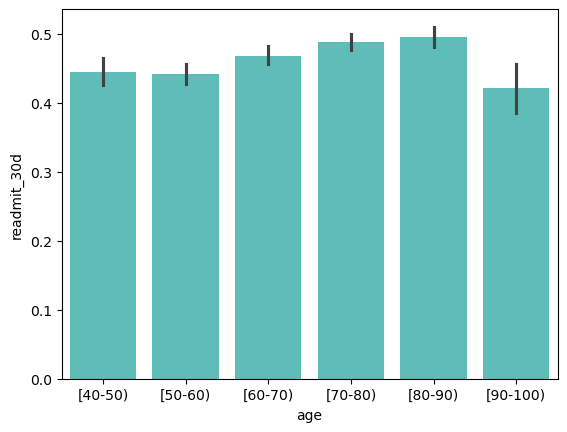

In [118]:
import seaborn as sns 
sns.barplot(data=df, x='age', y='readmit_30d', color= "#4ECDC4")

A rising readmission rate is observed with increasing age up to the 80–90 age group. This suggests that age is a significant risk factor. The 90–100 age group shows a decrease, possibly due to a small sample size or external factors not observed in the dataset.

### 3. Pior use of the heatlh system

In [119]:
#Group
previous = df.groupby("readmit_30d")[["n_inpatient","n_outpatient","n_emergency"]].agg("mean","count","sum")
print(previous)

             n_inpatient  n_outpatient  n_emergency
readmit_30d                                        
0               0.380190      0.258871     0.108561
1               0.881657      0.487579     0.274545


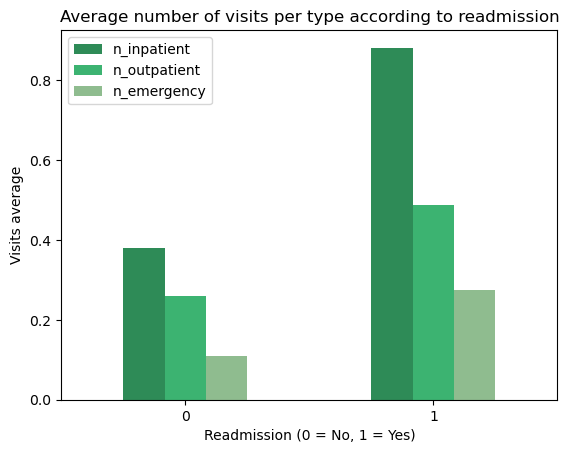

In [120]:
import matplotlib.pyplot as plt

previous.plot(kind="bar", color=["seagreen", "mediumseagreen", "darkseagreen"])
plt.ylabel("Visits average")
plt.xlabel("Readmission (0 = No, 1 = Yes)")
plt.title("Average number of visits per type according to readmission")
plt.xticks(rotation=0)
plt.show()

The analysis shows that readmitted patients have significantly greater use of the healthcare system in the previous year, especially hospitalizations (n_inpatient). This variable is twice its average value compared to the non-readmitted group, suggesting that recent history is a strong predictor of future risk.

### 4. Complexity of the clinical case

In [132]:
#Group
complex = df.groupby("readmit_30d")[["time_in_hospital",
                            "n_lab_procedures",
                            "n_procedures",
                            "n_medications"]].mean()
print(complex)

             time_in_hospital  n_lab_procedures  n_procedures  n_medications
readmit_30d                                                                 
0                    4.331345         42.625245      1.424204      15.972445
1                    4.590778         43.934405      1.271397      16.567892


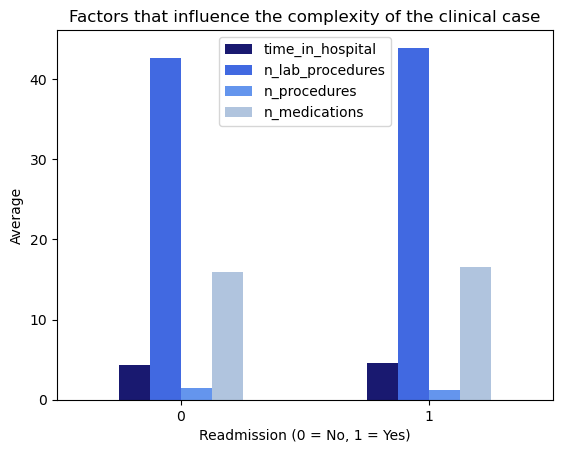

In [122]:
complex.plot(kind="bar", color=["midnightblue", "royalblue", "cornflowerblue", "lightsteelblue"])
plt.ylabel("Average")
plt.xlabel("Readmission (0 = No, 1 = Yes)")
plt.title("Factors that influence the complexity of the clinical case")
plt.xticks(rotation=0)
plt.show()

Here we have several variables:
- Length of hospital stay: A longer stay could reflect greater clinical severity, although the observed effect is slight compared to the previous history.
- Laboratory tests: Readmitted patients have a slight increase in the number of laboratory tests performed.
- Procedures: We see that readmitted patients underwent slightly fewer procedures than those not readmitted.
- Medications: Readmitted patients receive slightly more medications.

Overall, the differences are small and do not appear to be an indicator of readmission.


### 5. Diagnoses

In [123]:
#Group
diag = df.groupby("diag_1")[["readmit_30d"]].agg(["mean", "count", "sum"])
print(diag)

                readmit_30d            
                       mean count   sum
diag_1                                 
Circulatory        0.479294  7824  3750
Diabetes           0.536348  1747   937
Digestive          0.474453  2329  1105
Injury             0.436375  1666   727
Missing            0.500000     4     2
Musculoskeletal    0.395367  1252   495
Other              0.451216  6498  2932
Respiratory        0.490761  3680  1806


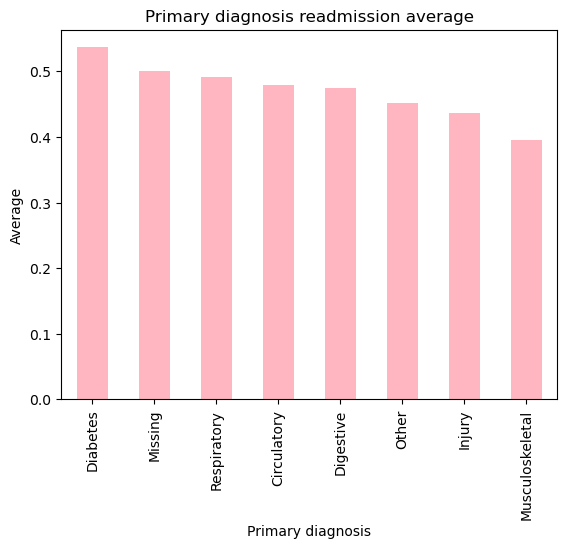

In [124]:
diag_1 = df.groupby("diag_1")["readmit_30d"].mean().sort_values(ascending=False)

diag_1.plot(kind="bar", color = "lightpink")
plt.ylabel("Average")
plt.xlabel("Primary diagnosis")
plt.title("Primary diagnosis readmission average")
plt.show()

We can see that patients with diabetes have the highest readmission rate at 53.6%, suggesting greater complexity in disease management or a greater chronic burden. This is followed by patients with respiratory and cardiovascular diseases at 49% and 48% respectively, which are typically chronic and recurrent conditions.

On the other hand, people with musculoskeletal diseases have a lower risk of readmission, as these are considered acute conditions.

### 6. Diabetes managment 

In [125]:
print('glucose_test values:', df['glucose_test'].unique())
print('diabetes_med values:', df['diabetes_med'].unique())
print('change values:', df['change'].unique())
print('A1Ctest values:', df['A1Ctest'].unique())

glucose_test values: ['no' 'normal' 'high']
diabetes_med values: ['yes' 'no']
change values: ['no' 'yes']
A1Ctest values: ['no' 'normal' 'high']


In [126]:
# Conversion for a better analysis
df2 = df.copy()

df2["glucose_high"] = (df2["glucose_test"] == "high").astype(int)
df2["A1C_high"] = (df2["A1Ctest"] == "high").astype(int)
df2["on_diabetes_med"] = (df2["diabetes_med"] == "yes").astype(int)
df2["med_changed"] = (df2["change"] == "yes").astype(int)

df2.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,...,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmit_30d,glucose_high,A1C_high,on_diabetes_med,med_changed
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,...,Other,no,no,no,yes,0,0,0,1,0
1,[70-80),3,34,2,13,0,0,0,Other,Other,...,Other,no,no,no,yes,0,0,0,1,0
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,...,Circulatory,no,no,yes,yes,1,0,0,1,1
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,...,Diabetes,no,no,yes,yes,1,0,0,1,1
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,...,Respiratory,no,no,no,yes,0,0,0,1,0


In [127]:
managment = df2.groupby("readmit_30d")[[
    "glucose_high",
    "A1C_high",
    "on_diabetes_med",
    "med_changed"]].mean()

print(managment)

             glucose_high  A1C_high  on_diabetes_med  med_changed
readmit_30d                                                      
0                0.024838  0.115356         0.744451     0.439831
1                0.030373  0.110516         0.796920     0.482985


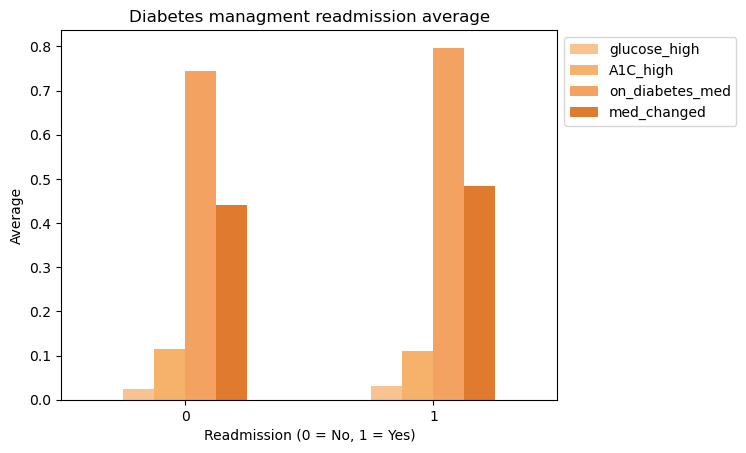

In [128]:
managment.plot(kind="bar", color = ["#f8c291", "#f6b26b", "#f4a261",  "#e07a2f"])
plt.ylabel("Average")
plt.xlabel("Readmission (0 = No, 1 = Yes)")
plt.title("Diabetes managment readmission average")
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.show()

Having high glucose levels or elevated A1C levels are indicators that show very little difference in terms of readmission. On the other hand, when medication is changed, patients have a 5% higher probability of being readmitted, while 80% of readmitted patients are receiving diabetes medication.

## EDA Conclusions

1. Although readmitted patients have a slightly longer length of stay and a greater number of medications, the differences are moderate. In comparison, the previous hospitalization history shows a much more marked gap, suggesting that readmission is more associated with chronic conditions or recurrent use of the system than with the isolated severity of the current event.

2. Analysis by primary diagnosis shows that patients with diabetes have the highest readmission rate (53.6%), followed by respiratory and circulatory conditions. In contrast, musculoskeletal diagnoses and injuries show a lower rate, suggesting that chronic conditions pose a greater risk than acute events.

3. Patients undergoing active diabetes treatment and those with medication changes show a higher probability of readmission, which could reflect clinical instability and a greater burden of chronic disease.

# Phase 2: Data preparation


In [129]:
X = df.drop(columns=["readmit_30d"])
y = df["readmit_30d"]

# convert Age as ordinal 
df["age_num"] = df["age"].str.extract(r'(\d+)').astype(int)
df.drop(columns=["age"], inplace=True)

df.head()


,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmit_30d,age_num
0,8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,0,70
1,3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,0,70
2,5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,1,50
3,2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,1,70
4,1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,0,60


In [139]:
from sklearn.preprocessing import StandardScaler

#One-Hot Encoding: Changing categorical to numeric
X =pd.get_dummies(X, drop_first=True)

#To check how many features I have
X.shape

(25000, 45)

## Train-Test Split

In [137]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y) #to maintain a 53/47 ratio in both sets

In [140]:
# Baseline Model 

import numpy as np
baseline_pred = np.zeros(len(y_test))

# Phase 3: Modeling (Logistic Regression)

In [141]:
# Scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
#Training

from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)

log_model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [143]:
# Predict 

y_pred = log_model.predict(X_test_scaled)
y_proba = log_model.predict_proba(X_test_scaled)[:,1]


In [ ]:
# Evaluation

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
        
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.60      0.78      0.68      2649
           1       0.63      0.41      0.50      2351

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.59      5000
weighted avg       0.61      0.61      0.59      5000

ROC-AUC: 0.6444865995193486
[[2074  575]
 [1385  966]]


**Confusion matrix:**
2074 → True negatives - *41% Recall*
575 → False positives
1385 → False negatives - *undetected readmited patients*
966 → True positives - *63% Precision* 

The model has reasonable precision (63%), but a low recall rate (41%), indicating that it is missing many patients who will actually be readmitted.
The ROC-AUC of 0.64 suggests moderate predictive ability, but there is clear room for improvement.

## Coefficients interpretation 

In [ ]:
coefficients = pd.DataFrame({
    "feature": X.columns,
    "coef": log_model.coef_[0]
}).sort_values(by="coef", ascending=False)

coefficients.head(10)


,feature,coef
5,n_inpatient,0.446259
6,n_emergency,0.209254
4,n_outpatient,0.141877
44,diabetes_med_yes,0.106084
10,age_[80-90),0.074979
9,age_[70-80),0.072472
1,n_lab_procedures,0.052078
18,diag_1_Diabetes,0.051797
0,time_in_hospital,0.047991
41,A1Ctest_no,0.040821


A recent history of hospitalizations is the main factor associated with readmission and outweighs the complexity of the current event.
Next, we see patients taking diabetes medication and the 80-90 age group, which confirms our findings from the EDA.

## Threshold adjustment

In [146]:
threshold = 0.4
y_pred_adjusted = (y_proba >= threshold).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

           0       0.66      0.42      0.51      2649
           1       0.53      0.75      0.63      2351

    accuracy                           0.58      5000
   macro avg       0.60      0.59      0.57      5000
weighted avg       0.60      0.58      0.56      5000



I adjusted the decision threshold to prioritize recall over precision, successfully identifying **75%** of patients who will be readmitted. In a hospital setting, this approach allows for broader preventative interventions, accepting a higher number of false positives to reduce the risk of adverse events.

## Second Model to compare

In [ ]:
# Training
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [150]:
# Predictions

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

# Evaluation 

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(confusion_matrix(y_test, y_pred_rf))



              precision    recall  f1-score   support

           0       0.61      0.69      0.64      2649
           1       0.59      0.50      0.54      2351

    accuracy                           0.60      5000
   macro avg       0.60      0.59      0.59      5000
weighted avg       0.60      0.60      0.59      5000

ROC-AUC: 0.6336955479777044
[[1822  827]
 [1181 1170]]


Recall 50% precision 61% Accuracy 60% y ROC-AUC 0.63. It means RF doesn´t exceed the adjusted logistics model.

In [151]:
importances = pd.DataFrame({
    "feature": X.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

importances.head(10)


,feature,importance
1,n_lab_procedures,0.154028
3,n_medications,0.134152
0,time_in_hospital,0.095643
2,n_procedures,0.059915
5,n_inpatient,0.056278
4,n_outpatient,0.027762
30,diag_2_Other,0.026568
37,diag_3_Other,0.026372
43,change_yes,0.021719
23,diag_1_Other,0.021439


Although a nonlinear model (Random Forest) was tested, no significant improvement was observed compared to logistic regression. This suggests that the relationships in the data are predominantly linear and that performance is limited by the information available in the dataset.



# Final Conclusions

**1. Prior Hospital Utilization Is the Strongest Predictor:** Patients with recent hospitalizations are significantly more likely to be readmitted, suggesting chronic disease burden or clinical instability.
**2. Age Increases Readmission Risk:** Readmission probability increases progressively up to the 80–90 age group. This supports the hypothesis that elderly populations are at higher risk of readmission.
**3. Chronic Conditions Show Higher Risk:** Patients with Diabetes as their primary diagnosis had the highest readmission rate (53.6%). Chronic conditions (e.g., circulatory and respiratory diseases) show higher risk compared to acute conditions (e.g., injury or musculoskeletal issues).
**4. Hospital Stay Complexity Has Moderate Impact:** Variables such as time in hospital, number of medications, laboratory procedures showed association with readmission, but their impact was weaker compared to prior system utilization.

This suggests that preventive strategies should prioritize patients with repeated system engagement rather than focusing only on acute episode severity.

**Selected Model:**

Using the default threshold (0.5), recall was only 41%. By lowering the threshold to 0.4:
- Recall increased to 75%
- Precision decreased to 53%
This adjustment prioritizes identifying high-risk patients, which is often more appropriate in healthcare contexts where missing high-risk individuals may lead to higher costs and worse outcomes.

**Limitations:**

- No socioeconomic variables available
- No data on medication adherence
- No post-discharge information
- Diagnoses grouped at category level (not granular ICD codes)
- No mortality data (possible bias in oldest age groups)

These limitations likely constrain predictive performance.